In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nufit
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.special import zeta
from scipy import stats

In [2]:
def load_data(file_name):
    data = np.load("RMFK_Results/" + file_name, allow_pickle = True)
    eps = data['e'][-1]
    f = data['fe'][-1]
    cdf = nufit.cdf_faster(eps, f)
    
    return eps, f, cdf

In [3]:
zeta3 = zeta(3)
T = 1.2
b_prime = 0

def norm(T, b_prime):
    result = (T**3 * (3/2) * zeta3) + b_prime
    return result

def cdf_fit(x, T, b_prime):

    def thermal(eps_cut, T):
        return eps_cut**2 / (np.exp(eps_cut/T) + 1) 
        
    num, err = quad(lambda eps_cut: thermal(eps_cut, T), 0, x)
    denom = norm(T, b_prime)

    return num/denom

In [4]:
T_values = np.linspace(1, 1.6, 200)
B_values = np.linspace(0, 2, 200)

def find_ks(eps, cdf_data, T_values, B_values):
    ks = np.zeros((len(T_values), len(B_values)))
                  
    for i, t in enumerate(T_values):
        for j, b in enumerate(B_values):
            cdf_fit_model = [cdf_fit(x, t, b) for x in eps]
            ks_val  = np.max(np.abs(cdf_fit_model - cdf_data))
            ks[i, j] = ks_val

    min_index = np.unravel_index(np.argmin(ks), ks.shape)
    best_t = T_values[min_index[0]]
    best_b = B_values[min_index[1]]

    return best_t, best_b

In [5]:
file_names = [
    "mass-300-life-0.010.npz", 
    "mass-300-life-0.013.npz",
    "mass-300-life-0.017.npz",
    "mass-300-life-0.022.npz",
    "mass-300-life-0.030.npz",
    "mass-300-life-0.040.npz",
    "mass-300-life-0.053.npz",
    "mass-300-life-0.070.npz",
    "mass-300-life-0.093.npz",
    "mass-300-life-0.122.npz",
    "mass-300-life-0.166.npz",
    "mass-300-life-0.221.npz",
    "mass-300-life-0.282.npz",
    "mass-300-life-0.373.npz",
    "mass-300-life-0.517.npz",
    "mass-300-life-0.664.npz",
    "mass-300-life-0.912.npz",
    "mass-300-life-1.236.npz",
    "mass-300-life-1.495.npz",
    "mass-300-life-1.846.npz"
]

In [6]:
cdf_fitted = [] 
cdf_data = []
epsilon = []
best_T = []
best_bp = []

for name in file_names:
    eps_long, f_long, cdf_long = load_data(name)
    eps = eps_long[:11]
    f = f_long[:11]
    cdf = cdf_long[:11]
    cdf_fit_model = [cdf_fit(x, T, b_prime) for x in eps]
    best_t, best_b = find_ks(eps, cdf, T_values, B_values)
    cdf_fitted.append(cdf_fit_model)
    cdf_data.append(cdf)
    epsilon.append(eps)
    best_T.append(best_t)
    best_bp.append(best_b)
    print(f"file: {name} - best T: {best_t}, best B prime: {best_b}")

file: mass-300-life-0.010.npz - best T: 1.114572864321608, best B prime: 0.03015075376884422
file: mass-300-life-0.013.npz - best T: 1.1266331658291457, best B prime: 0.03015075376884422
file: mass-300-life-0.017.npz - best T: 1.1417085427135678, best B prime: 0.020100502512562814
file: mass-300-life-0.022.npz - best T: 1.1567839195979899, best B prime: 0.03015075376884422
file: mass-300-life-0.030.npz - best T: 1.177889447236181, best B prime: 0.03015075376884422
file: mass-300-life-0.040.npz - best T: 1.1989949748743718, best B prime: 0.04020100502512563
file: mass-300-life-0.053.npz - best T: 1.214070351758794, best B prime: 0.09045226130653267
file: mass-300-life-0.070.npz - best T: 1.2291457286432161, best B prime: 0.15075376884422112
file: mass-300-life-0.093.npz - best T: 1.2412060301507537, best B prime: 0.23115577889447236
file: mass-300-life-0.122.npz - best T: 1.2412060301507537, best B prime: 0.3417085427135678
file: mass-300-life-0.166.npz - best T: 1.235175879396985, best

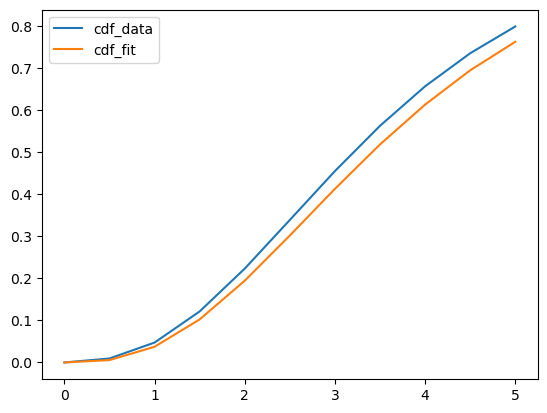

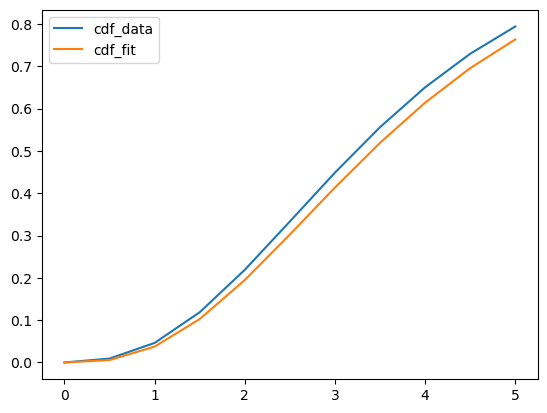

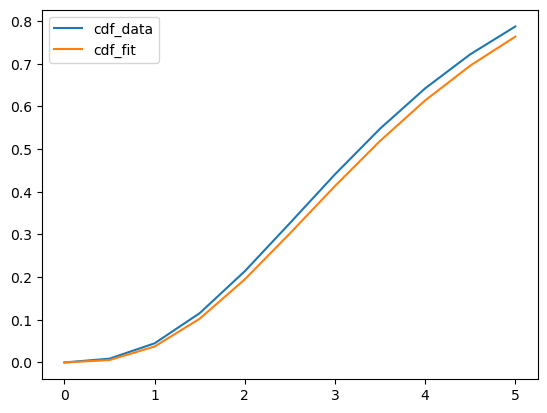

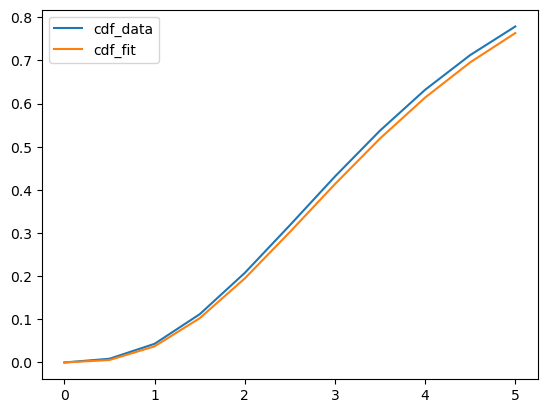

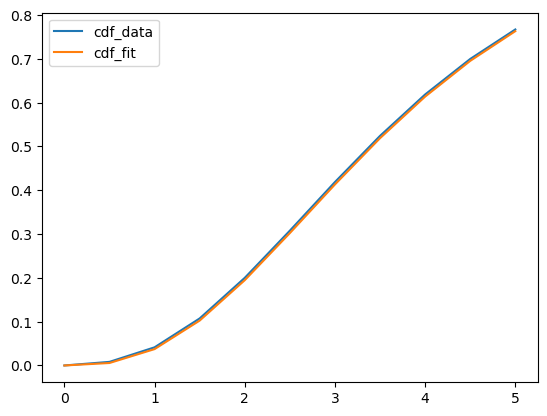

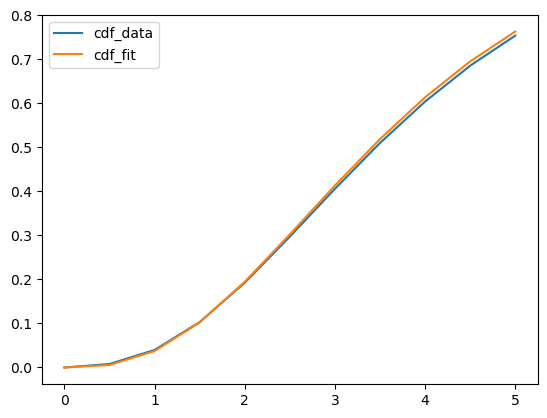

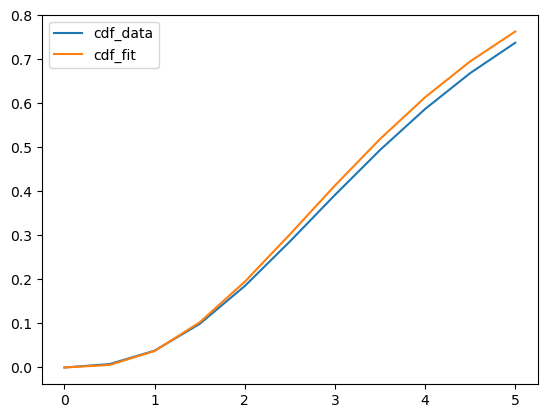

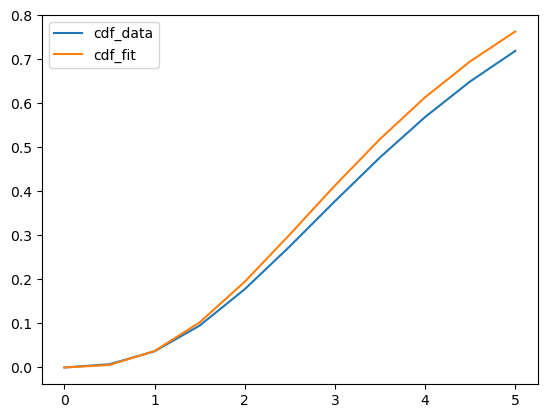

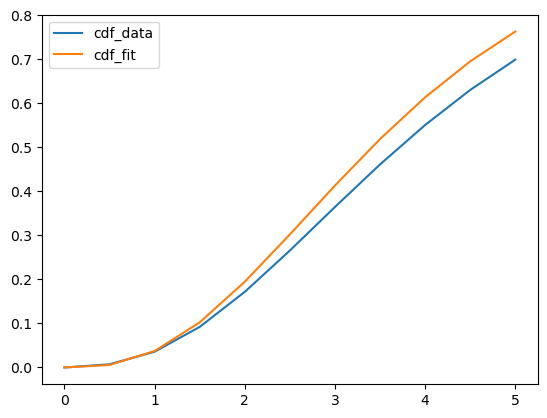

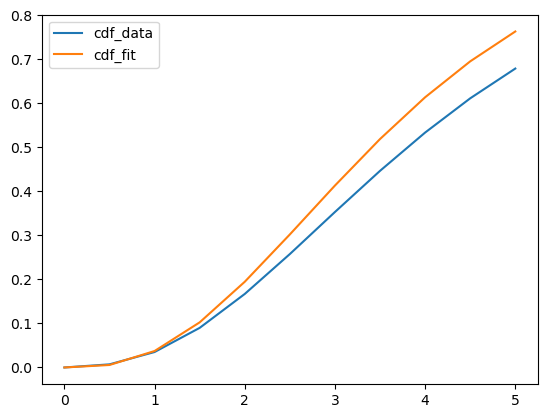

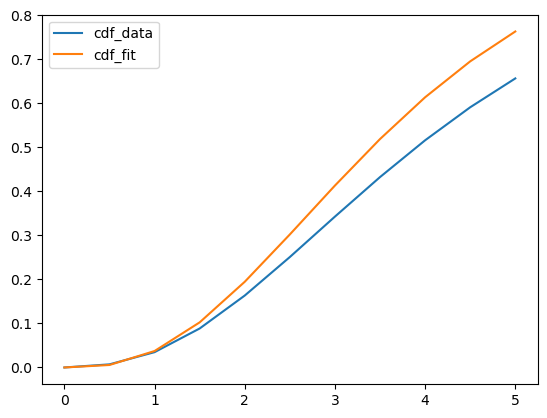

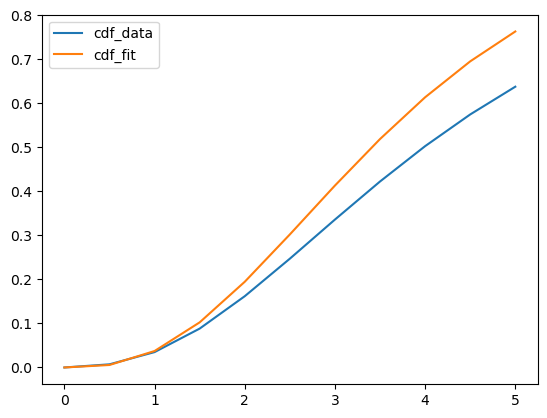

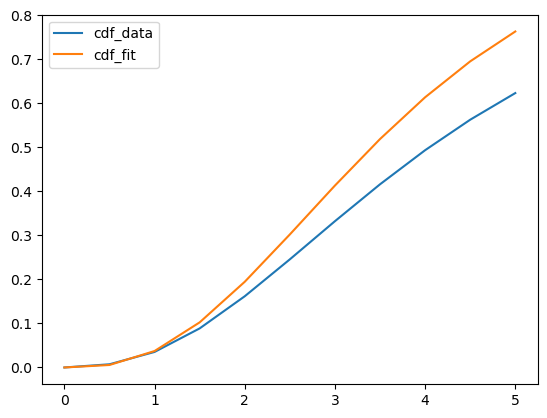

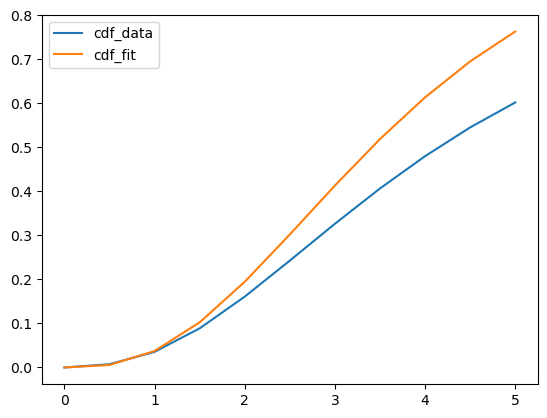

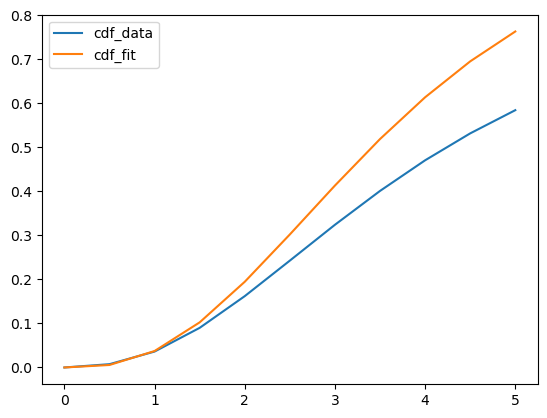

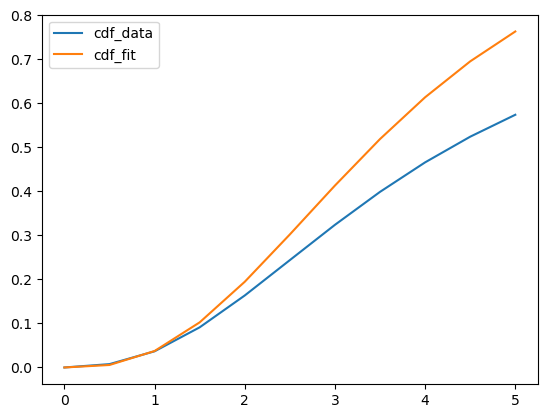

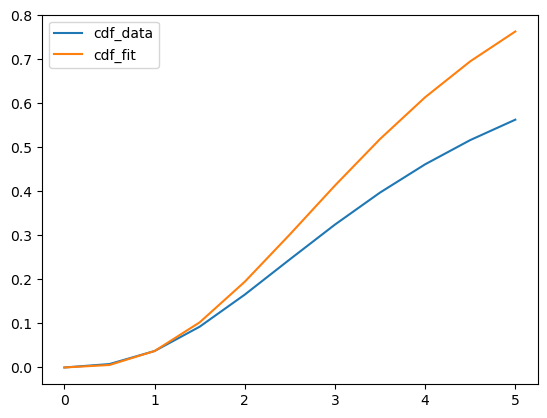

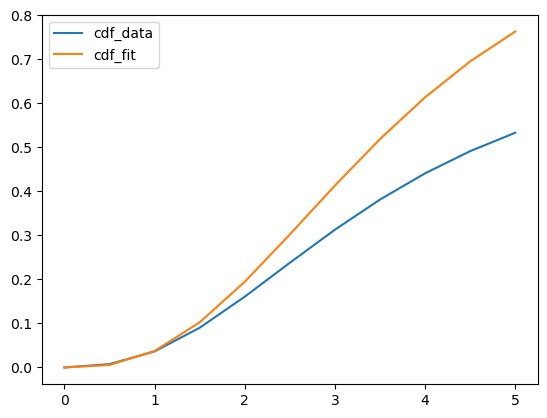

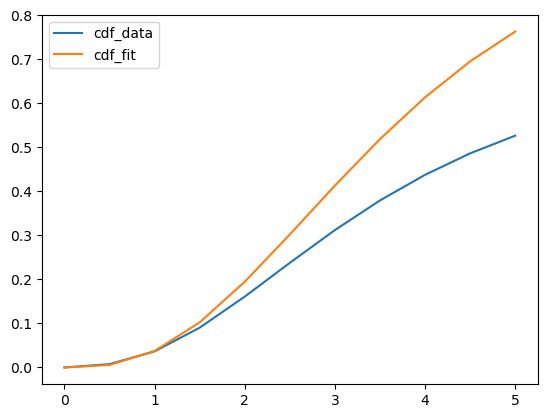

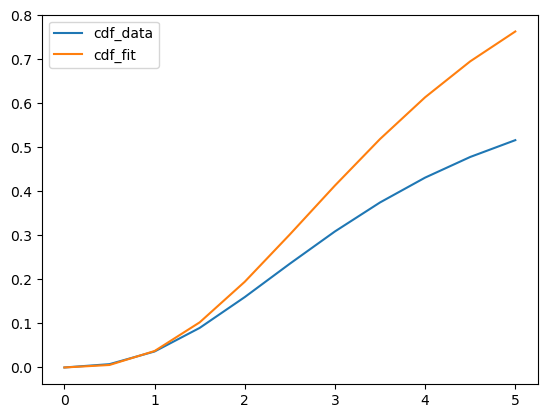

In [7]:
for i in range(len(cdf_fitted)):
    plt.figure()
    plt.plot(epsilon[i], cdf_data[i], label = 'cdf_data')
    plt.plot(epsilon[i], cdf_fitted[i], label = 'cdf_fit')
    plt.legend()

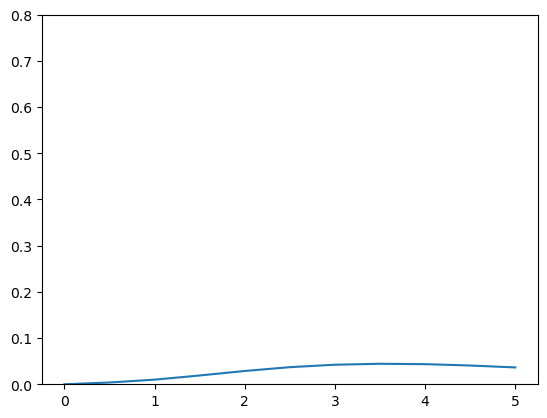

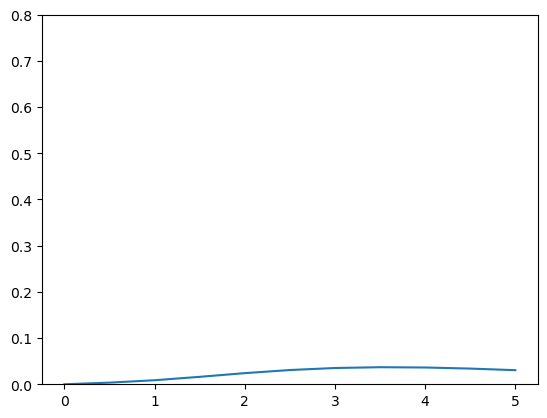

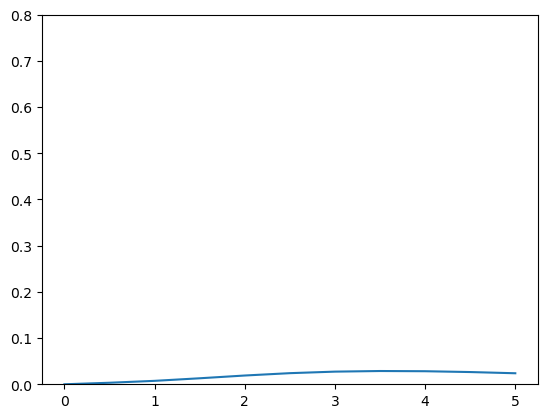

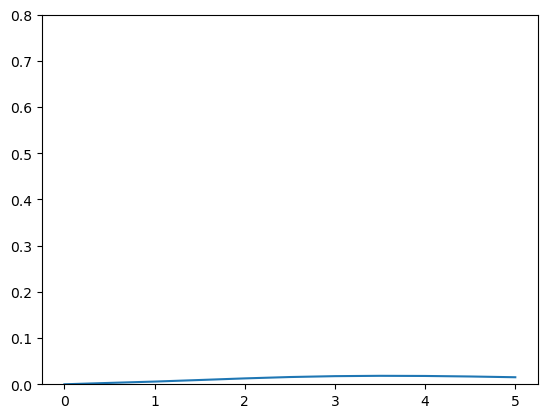

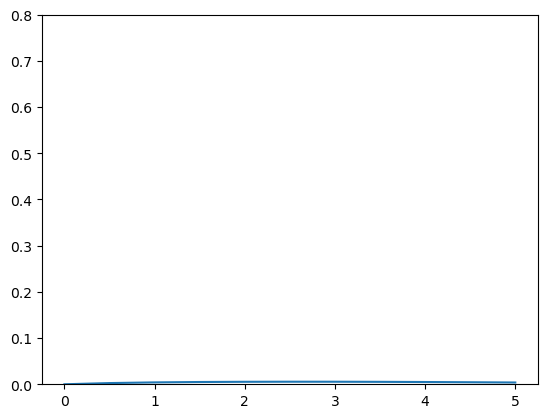

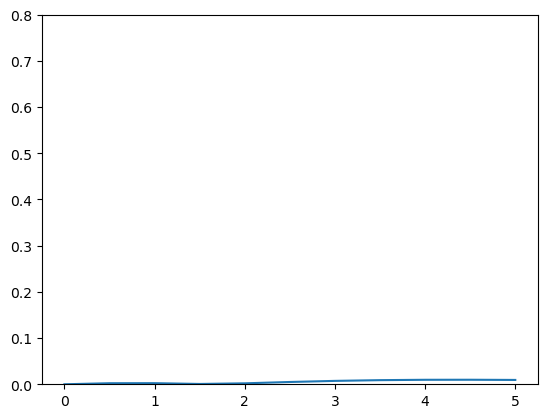

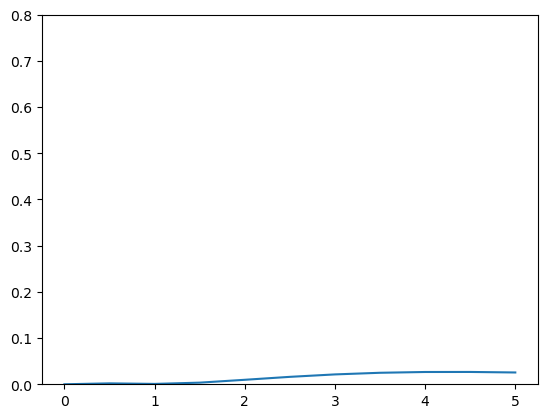

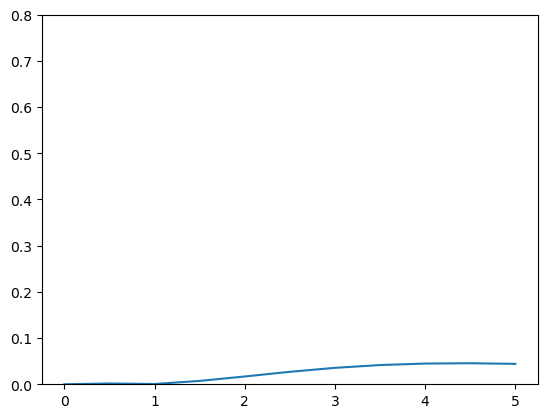

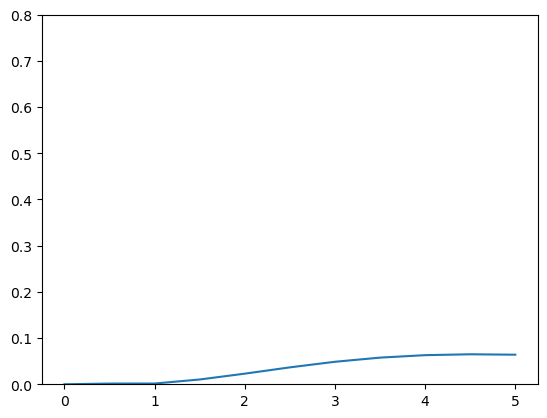

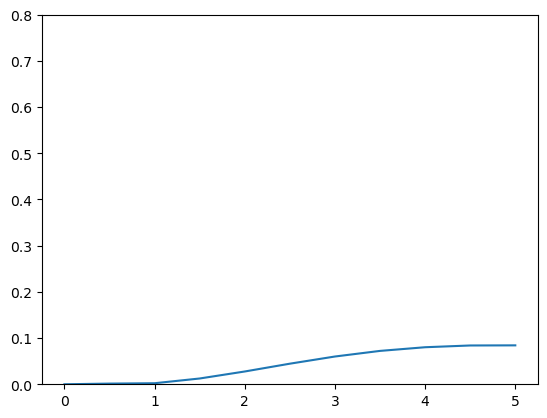

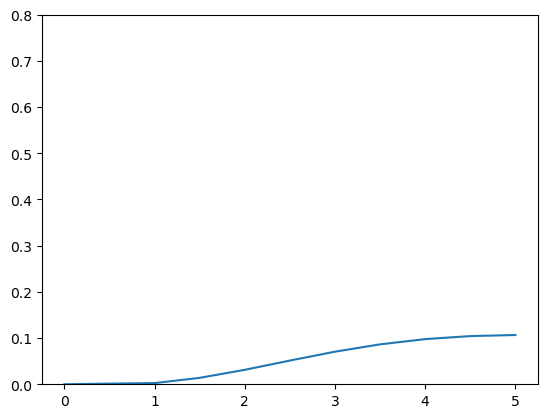

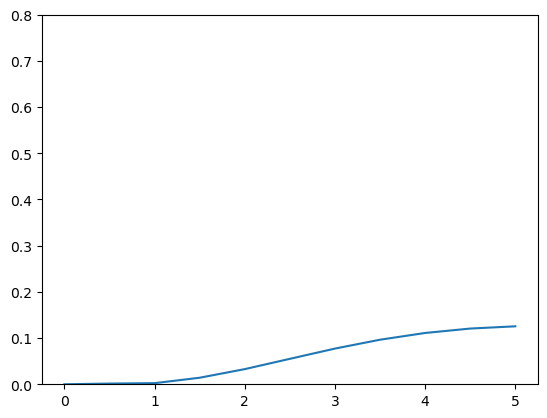

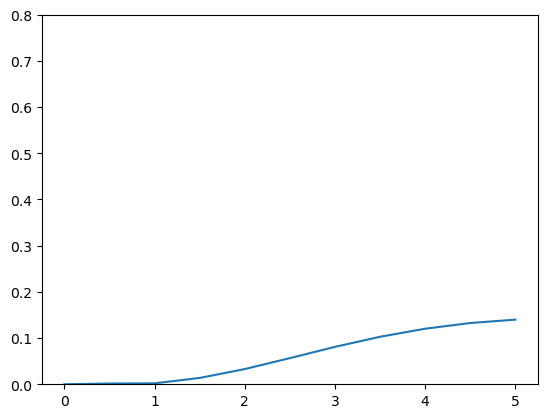

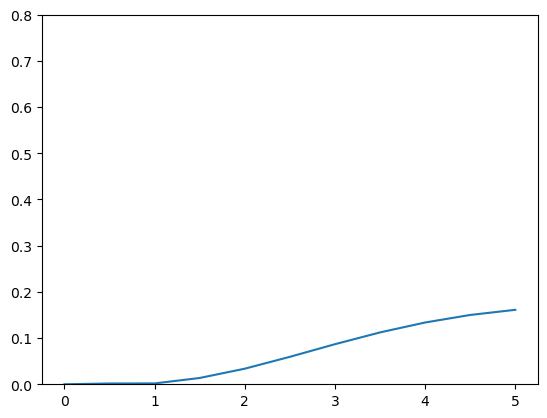

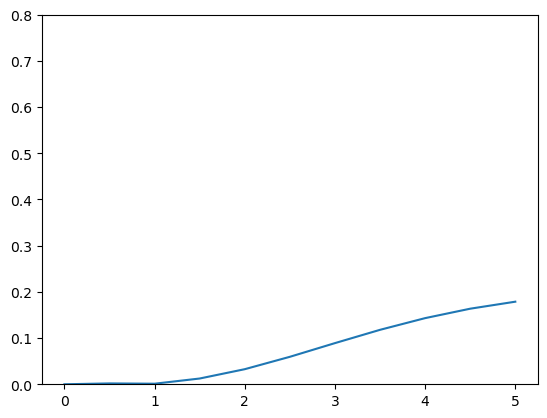

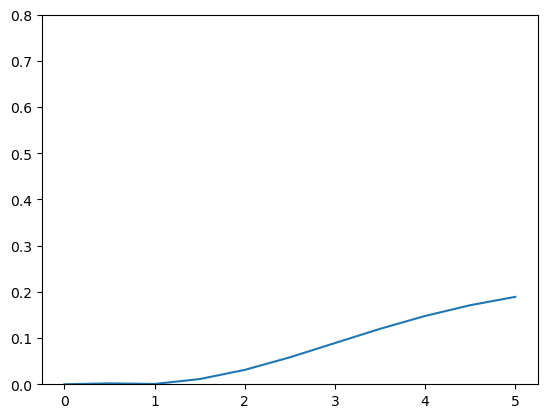

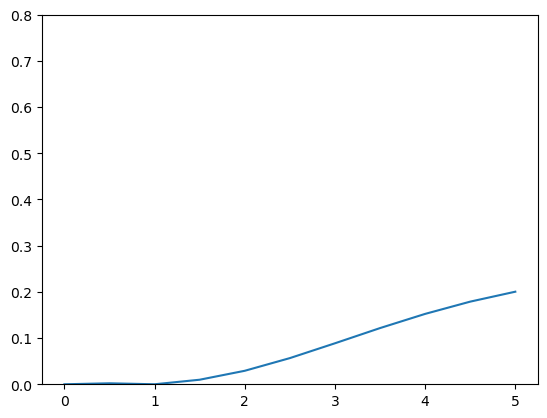

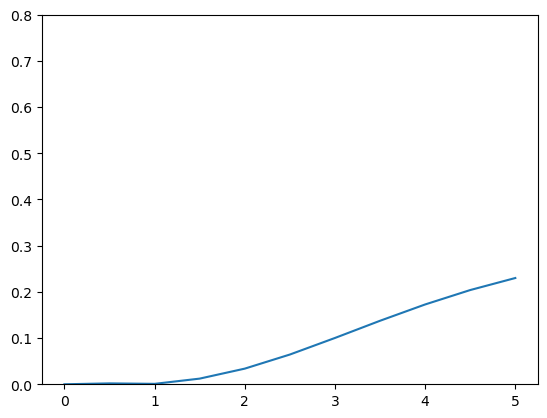

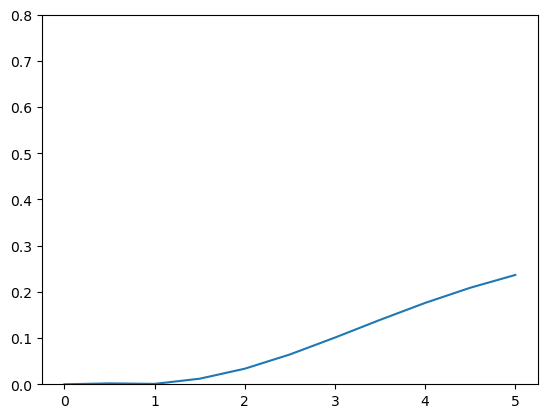

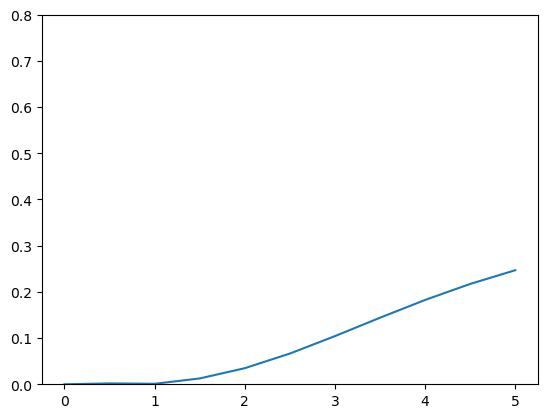

In [8]:
for i in range(len(cdf_fitted)):
    plt.figure()
    plt.plot(epsilon[i], np.abs(cdf_fitted[i] - cdf_data[i]))
    plt.ylim(0,0.8)

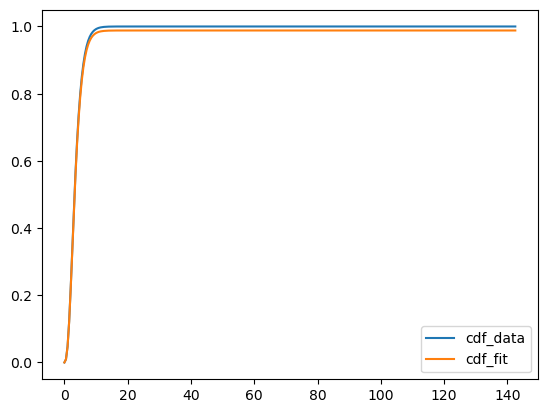

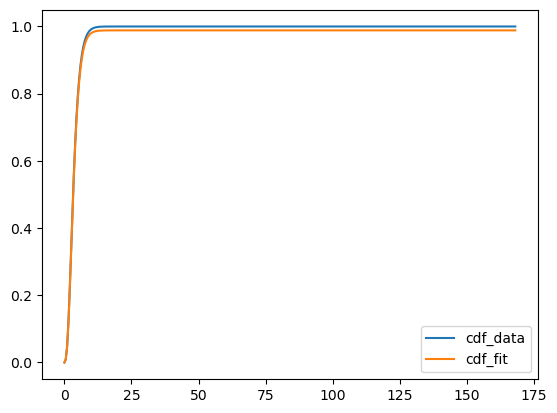

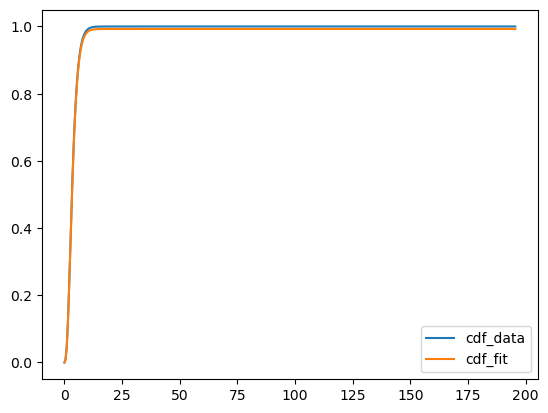

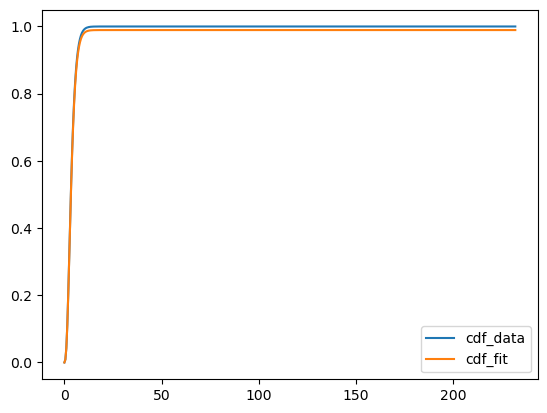

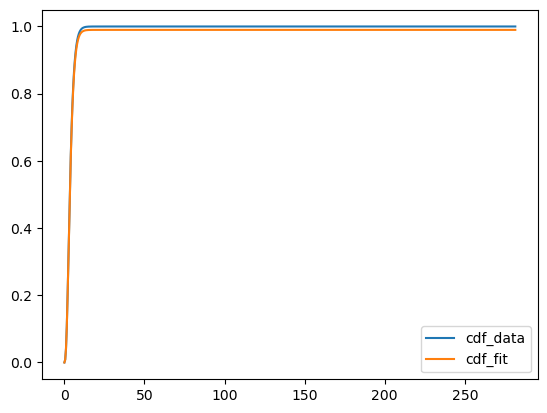

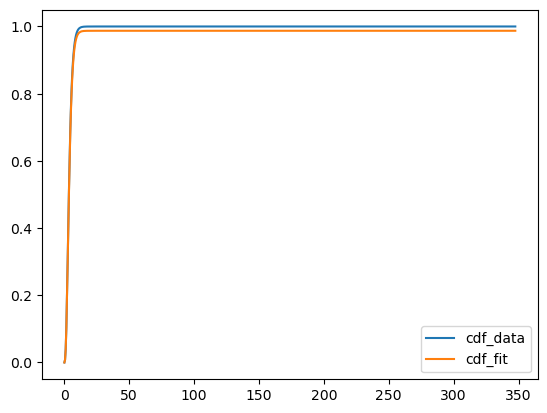

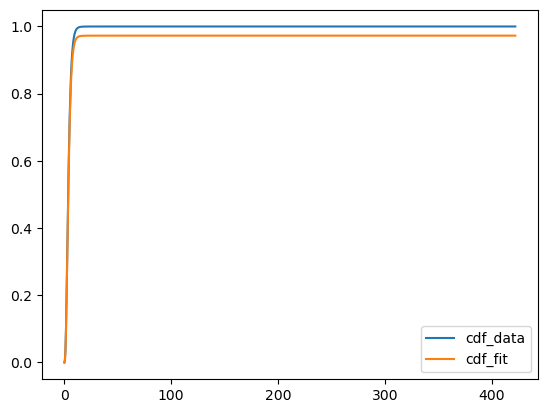

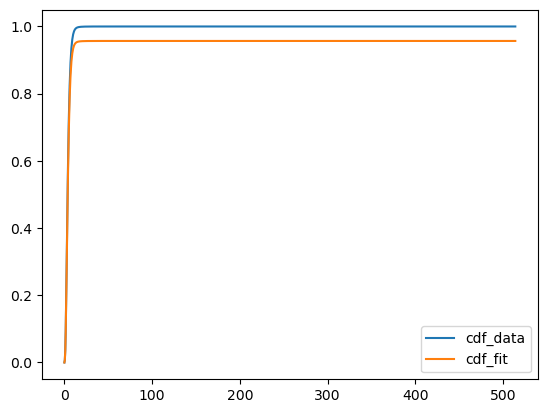

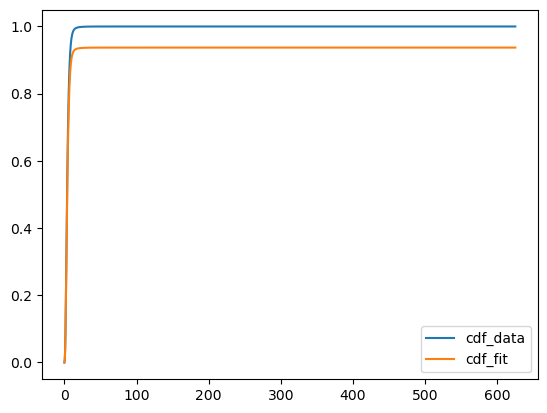

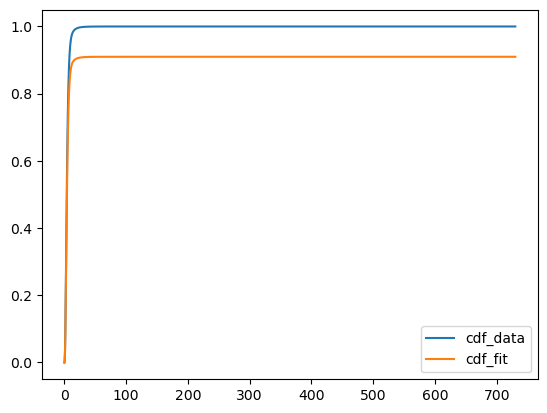

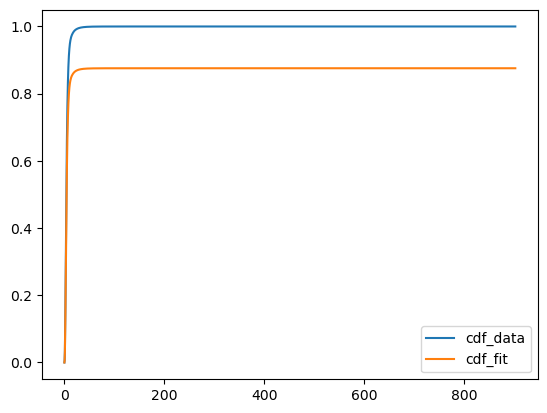

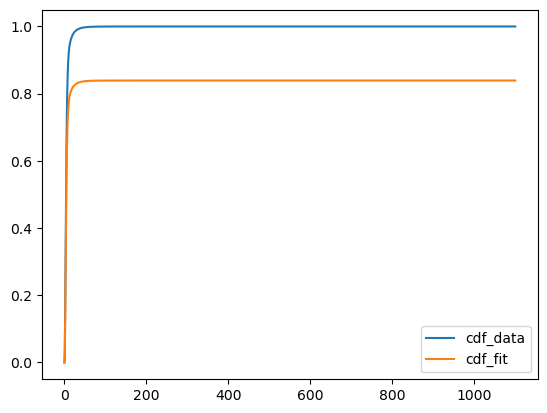

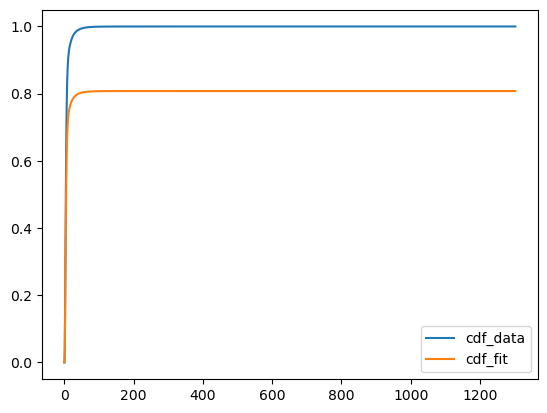

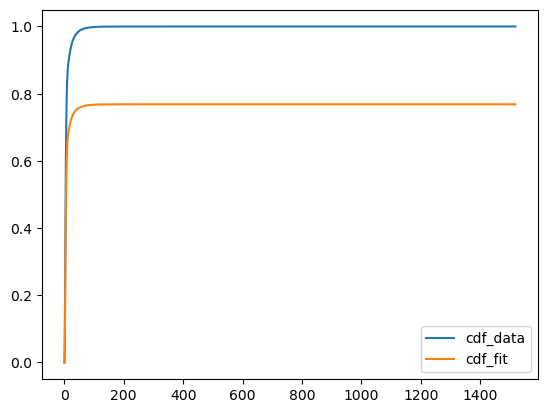

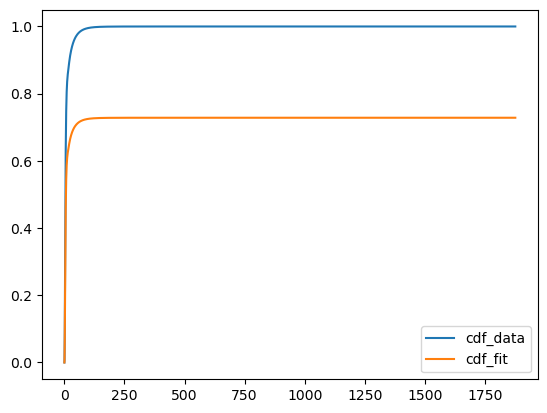

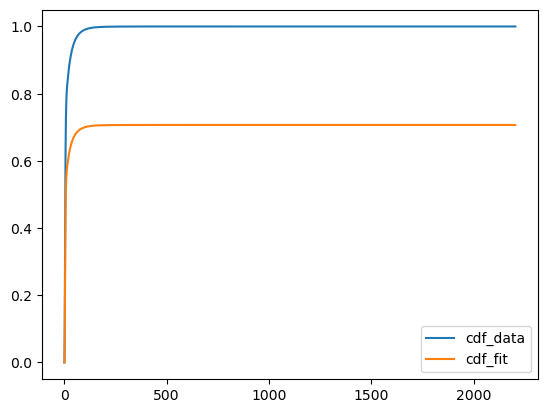

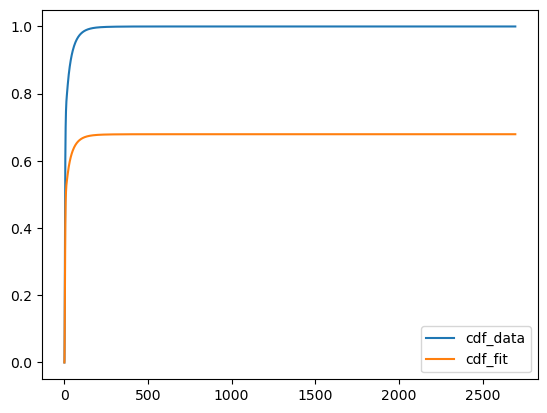

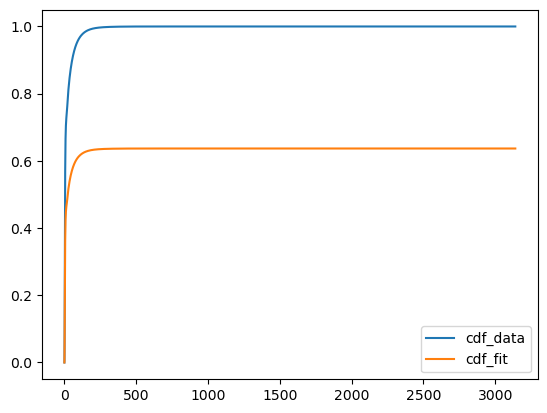

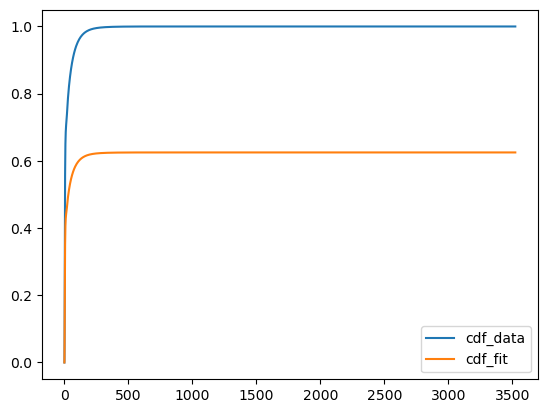

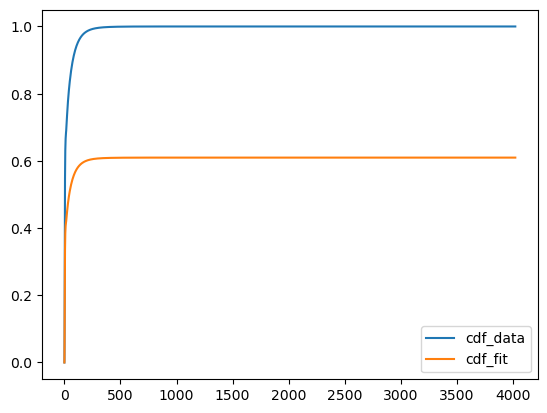

In [9]:
bfunc = []
for i, name in enumerate(file_names):
    eps, f, cdf = load_data(name)
    cdf_fitt = cdf*norm(best_T[i],0)/norm(best_T[i], best_bp[i])
    bfunc.append(cdf - cdf_fitt)
    plt.figure()
    plt.plot(eps, cdf, label = 'cdf_data')
    plt.plot(eps, cdf_fitt, label = 'cdf_fit')
    plt.legend()

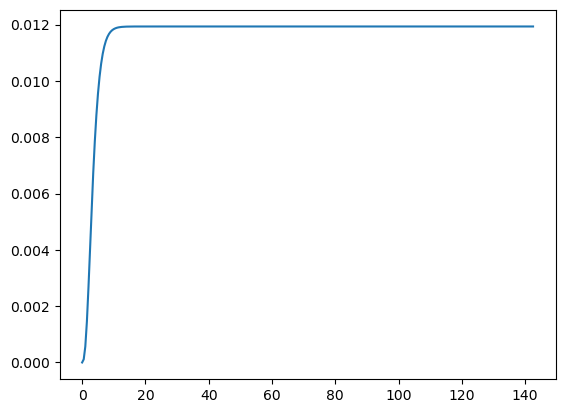

In [10]:
eps, f, cdf = load_data(file_names[0])
plt.plot(eps, bfunc[0])

In [11]:
def bfunc_fit(x, frac, d):
    return (frac * (1/6) * (6 - ((x/d)**3 + 3 * (x/d)**2 + 6 * (x/d) + 6) * np.exp(-x/d)))

In [12]:
d_vals = np.linspace(-3, 3, 200)
def find_d(eps, frac, bfunc, d_vals):
    best_d = np.zeros(len(d_vals))
                  
    for i, d in enumerate(d_vals):
        bfunc_fitt = [bfunc_fit(x, frac, d) for x in eps]
        ks_val  = np.max(np.abs(bfunc_fitt - bfunc))
        best_d[i] = ks_val

    min_index = np.unravel_index(np.argmin(best_d), best_d.shape)
    best_D = d_vals[min_index]
        
    return best_D

In [13]:
best_ds = []

for i, name in enumerate(file_names):
    eps, f, cdf = load_data(name)
    frac = best_bp[i]/norm(best_T[i], best_bp[i])
    best_d = find_d(eps, frac, bfunc[i], d_vals)
    best_ds.append(best_d)
    print(f"file: {name} - best d: {best_d}")

/var/folders/kl/cgktwqnn1f7_94dngb87_j8c0000gs/T/ipykernel_1929/2979916313.py:2: RuntimeWarning: overflow encountered in scalar multiply
  return (frac * (1/6) * (6 - ((x/d)**3 + 3 * (x/d)**2 + 6 * (x/d) + 6) * np.exp(-x/d)))
/var/folders/kl/cgktwqnn1f7_94dngb87_j8c0000gs/T/ipykernel_1929/2979916313.py:2: RuntimeWarning: overflow encountered in exp
  return (frac * (1/6) * (6 - ((x/d)**3 + 3 * (x/d)**2 + 6 * (x/d) + 6) * np.exp(-x/d)))


file: mass-300-life-0.010.npz - best d: 0.8592964824120601
file: mass-300-life-0.013.npz - best d: 0.8894472361809043
file: mass-300-life-0.017.npz - best d: 0.8894472361809043
file: mass-300-life-0.022.npz - best d: 0.9195979899497484
file: mass-300-life-0.030.npz - best d: 0.9195979899497484
file: mass-300-life-0.040.npz - best d: 0.949748743718593
file: mass-300-life-0.053.npz - best d: 0.949748743718593
file: mass-300-life-0.070.npz - best d: 0.9798994974874371
file: mass-300-life-0.093.npz - best d: 1.0100502512562812
file: mass-300-life-0.122.npz - best d: 1.0402010050251258
file: mass-300-life-0.166.npz - best d: 1.100502512562814
file: mass-300-life-0.221.npz - best d: 1.1306532663316577
file: mass-300-life-0.282.npz - best d: 1.1608040201005023
file: mass-300-life-0.373.npz - best d: 1.2512562814070352
file: mass-300-life-0.517.npz - best d: 1.341708542713568
file: mass-300-life-0.664.npz - best d: 1.4020100502512562
file: mass-300-life-0.912.npz - best d: 1.492462311557789
fi

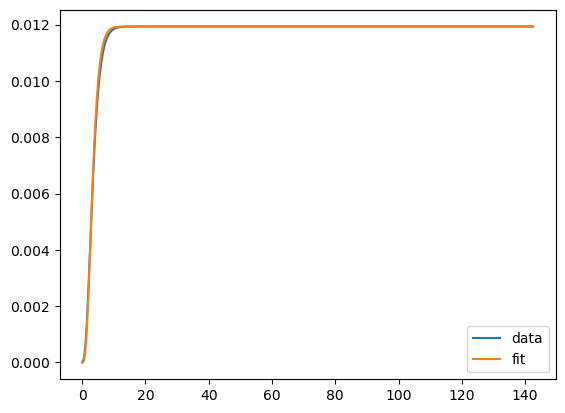

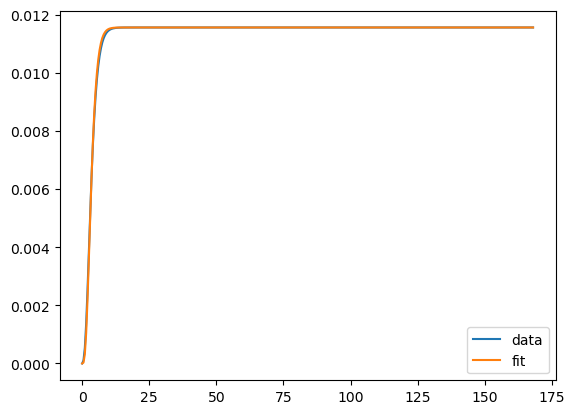

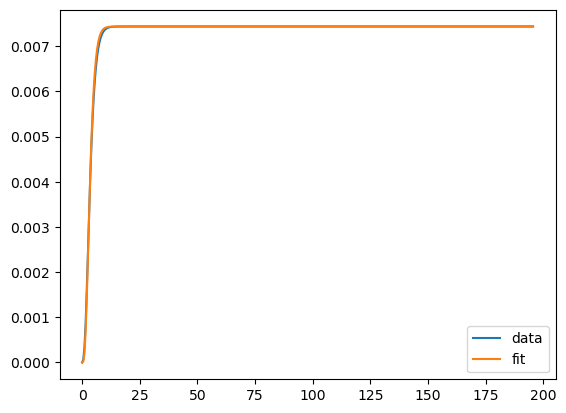

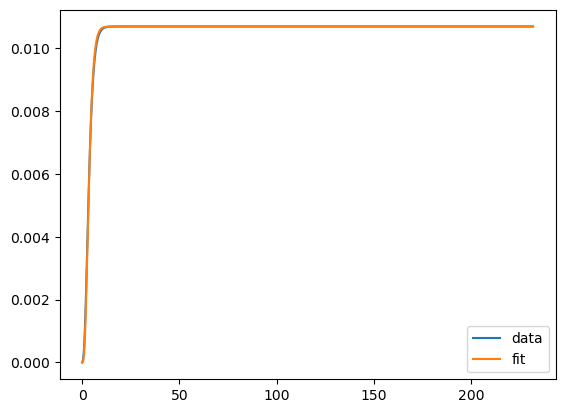

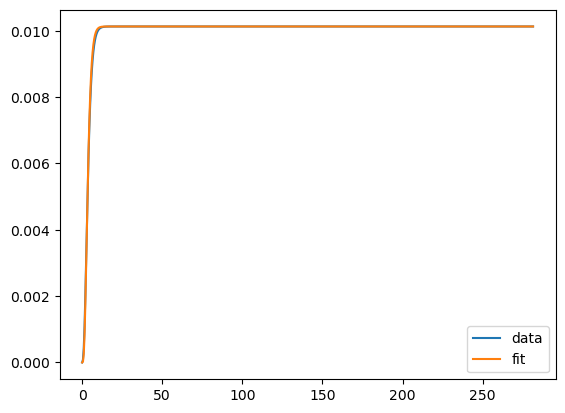

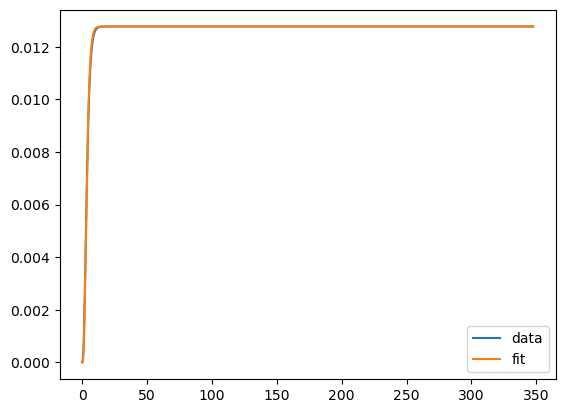

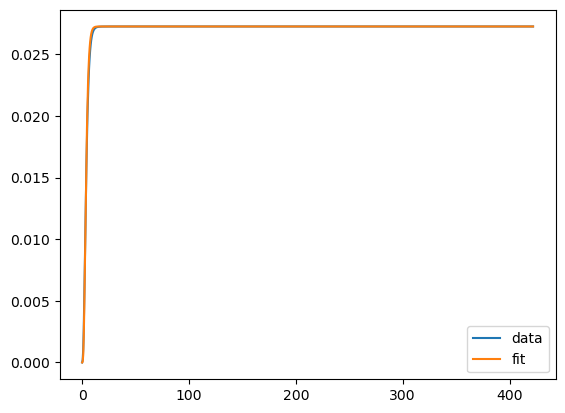

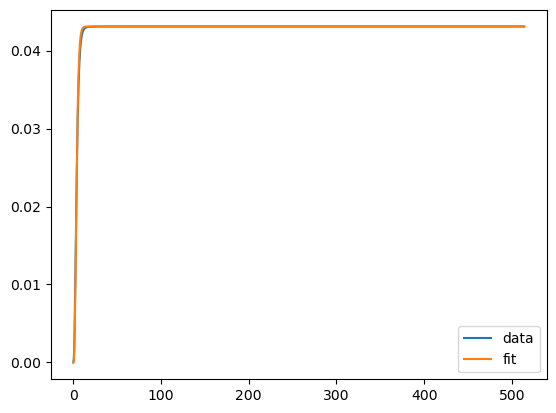

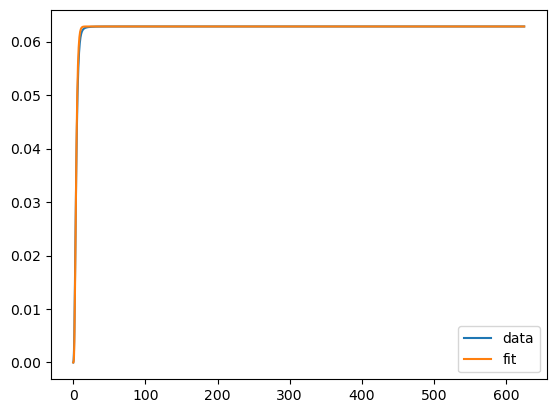

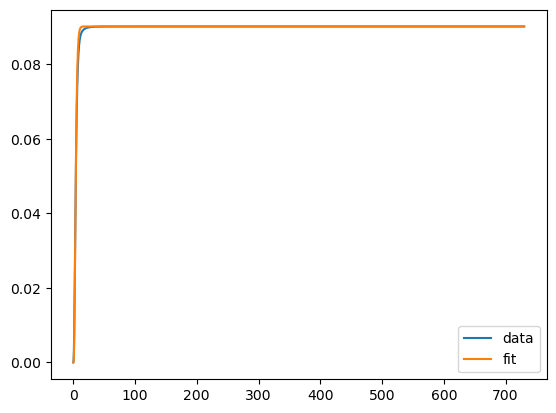

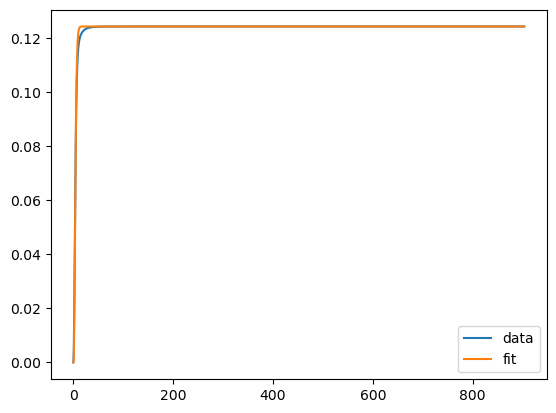

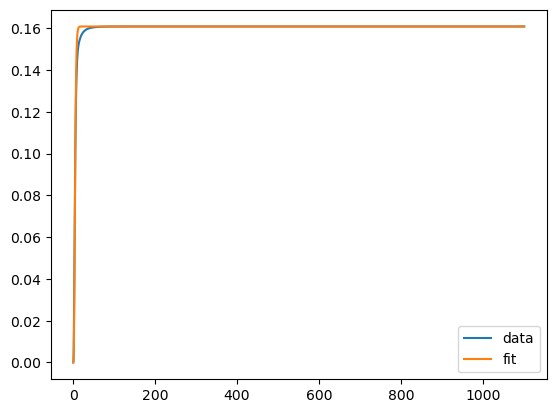

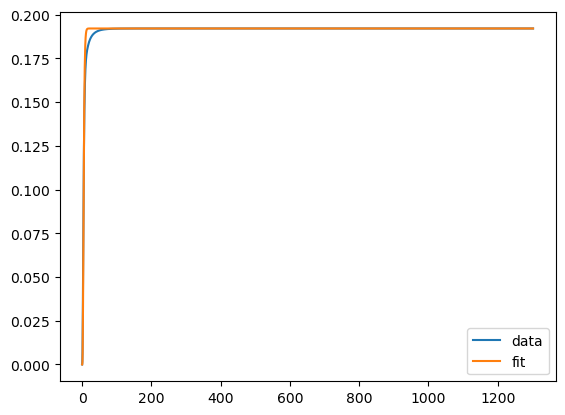

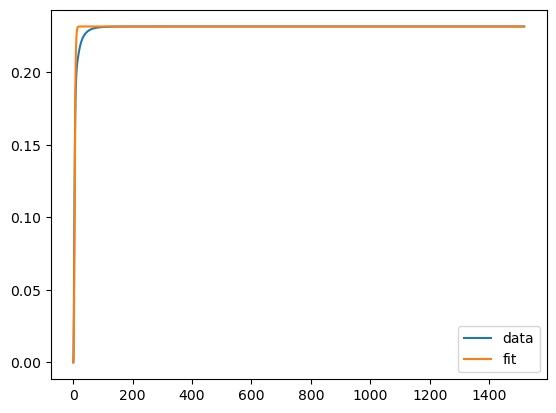

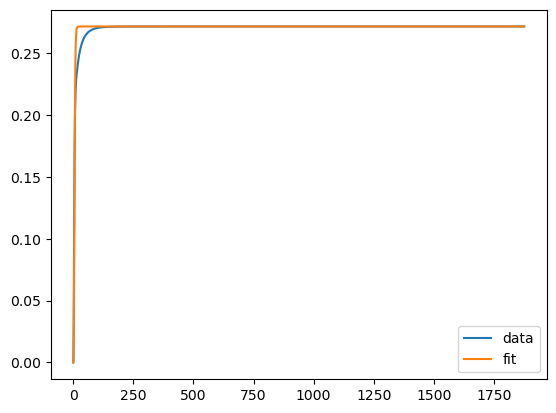

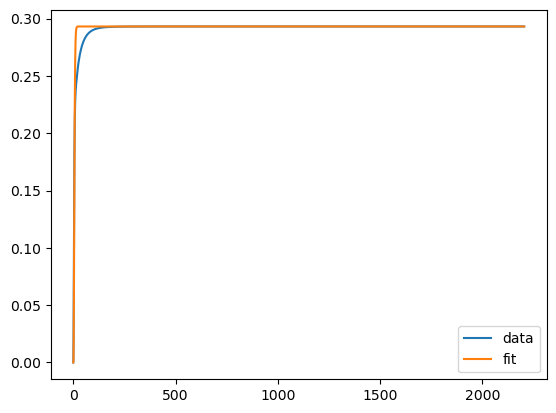

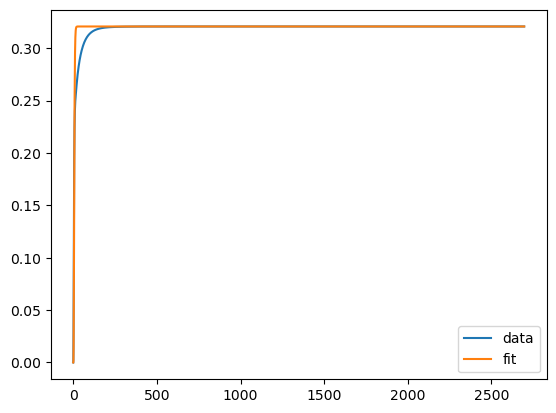

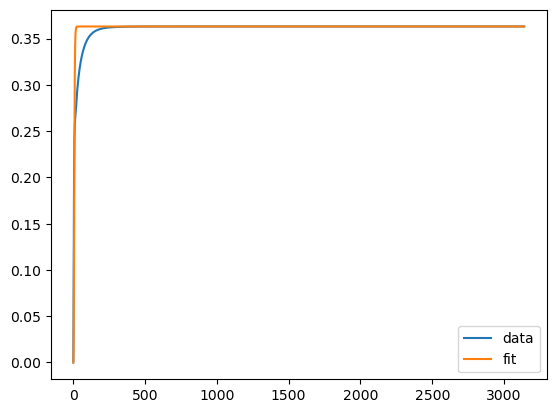

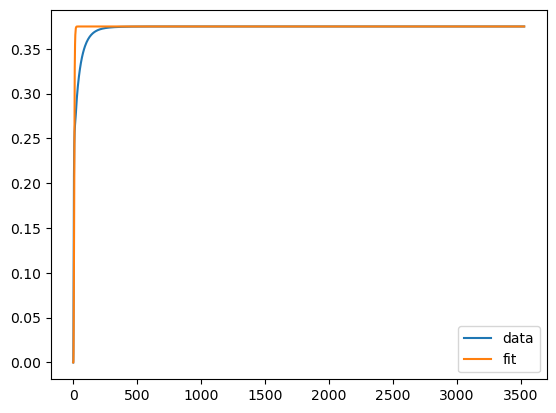

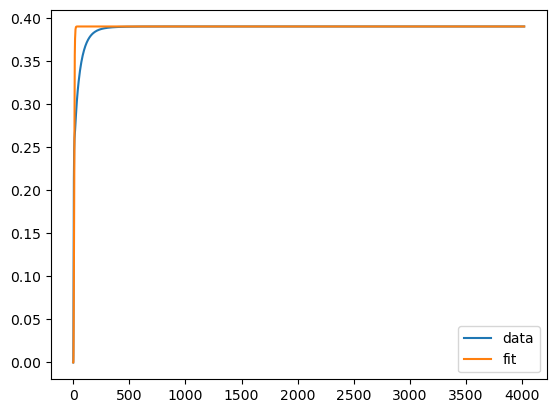

In [14]:
for i, name in enumerate(file_names):
    eps, f, cdf = load_data(name)
    frac = best_bp[i]/norm(best_T[i], best_bp[i])
    model = [bfunc_fit(x, frac, best_ds[i]) for x in eps]
    plt.figure()
    plt.plot(eps, bfunc[i], label = 'data')
    plt.plot(eps, model, label ='fit')
    plt.legend()
    